In [1]:
import os
import numpy as np
import glob
import cv2
import matplotlib.pyplot as plt
import imageio
import pickle

from sklearn.model_selection import train_test_split

%matplotlib inline

In [2]:
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers import Cropping2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import Callback
from keras.optimizers import Adam

import tensorflow as tf

Using TensorFlow backend.


# Preparation

Like the previous notebook, function will be placed on TOP to ease loading

In [3]:
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)
        
def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [4]:
def resize_to_original(img, target_size):
    current_height, current_width = img.shape
    target_height, target_width = target_size
    if current_height >= target_height and current_width >= target_width:
        # we are in case where we expanded with black
        return img[:target_height, :target_width]
    else:
        scale = max(target_height, target_width) / 512
        scaled_image = cv2.resize(img, None, fx=scale, fy=scale, interpolation = cv2.INTER_NEAREST)
        return scaled_image[:target_height, :target_width]
    return img

def compute_IoU(pred, mask, trigger=0.999):
    pred = (pred>trigger)
    mask = (mask>0.9)
    union = np.logical_or(pred, mask)
    intersection = np.logical_and(pred, mask)
    return intersection.sum()/union.sum()

In [5]:
# def mean_iou(y_true, y_pred):
#     prec = []
#     for t in np.arange(0.5, 1.0, 0.05):
#         y_pred_ = tf.to_int32(y_pred > t)
#         score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
#         K.get_session().run(tf.local_variables_initializer())
#         with tf.control_dependencies([up_opt]):
#             score = tf.identity(score)
#         prec.append(score)
#     return K.mean(K.stack(prec), axis=0)

We can now load our datas prepared previously. This include matrice of dimensions, images boosted, and masks resized to proper dimensions.

In [8]:
dimensions = np.array(load_obj("datas/dimensions"))
data = np.load('datas/dataset_multi_matrices_large.npz')
X1_train, X1_test, X2_train, X2_test, X3_train, X3_test, y_train, y_test, dim_train, dim_test = train_test_split(data["X1"], data["X2"], data["X3"], data["y"], dimensions, test_size=0.1, random_state=42)

In [9]:
print("Pre-processed images")
print(X1_train.shape, " - ",  X1_train.dtype)
print(X1_test.shape, " - ",  X1_test.dtype)

print("\nAdaptated Threshold images")
print(X2_train.shape, " - ",  X2_train.dtype)
print(X2_test.shape, " - ",  X2_test.dtype)

print("\nInitial images")
print(X3_train.shape, " - ", X3_train.dtype)
print(X3_test.shape, " - ", X3_test.dtype)

print("\nmask")
print(y_train.shape, " - ", y_train.dtype)
print(y_test.shape, " - ", y_test.dtype)

print("\ndimension")
print(dim_train.shape, " - ", dim_test.shape, " - ", dim_train.dtype)

Pre-processed images
(603, 256, 256, 1)  -  uint8
(67, 256, 256, 1)  -  uint8

Adaptated Threshold images
(603, 256, 256, 1)  -  uint8
(67, 256, 256, 1)  -  uint8

Initial images
(603, 256, 256, 3)  -  uint8
(67, 256, 256, 3)  -  uint8

mask
(603, 256, 256, 1)  -  uint8
(67, 256, 256, 1)  -  uint8

dimension
(603, 2)  -  (67, 2)  -  int32


In [10]:
h, w, c = X1_train.shape[1:]
BATCH_SIZE = 3
NB_IMAGES_TRAIN = X1_train.shape[0]
NB_IMAGES_TEST = X1_test.shape[0]
EPOCHS = 50
SEED = 42

# Model U-Net Extended

Compare to standard Unet tried previously, an extended will be tried. The architecture is the following one :

<img src="img/extended_unet (1).png"/>

We can consider it as a "multi arm inputs". As the previous model, padding is "same" tou have input size = output size. Similarly to previous model, the model is prepared under "models/model_extended.py" with a callback  to save output at every epoch.

Epoch 1/50
201/201 [==============================] - 19s 96ms/step - loss: 0.1818 - binary_crossentropy: 0.1818 - val_loss: 0.0859 - val_binary_crossentropy: 0.0859
Epoch 2/50
201/201 [==============================] - 16s 80ms/step - loss: 0.0981 - binary_crossentropy: 0.0981 - val_loss: 0.0840 - val_binary_crossentropy: 0.0840
Epoch 3/50
201/201 [==============================] - 16s 80ms/step - loss: 0.0937 - binary_crossentropy: 0.0937 - val_loss: 0.0678 - val_binary_crossentropy: 0.0678
Epoch 4/50
201/201 [==============================] - 16s 80ms/step - loss: 0.0868 - binary_crossentropy: 0.0868 - val_loss: 0.0793 - val_binary_crossentropy: 0.0793
Epoch 5/50
201/201 [==============================] - 16s 81ms/step - loss: 0.0821 - binary_crossentropy: 0.0821 - val_loss: 0.0743 - val_binary_crossentropy: 0.0743
Epoch 6/50
201/201 [==============================] - 16s 81ms/step - loss: 0.0771 - binary_crossentropy: 0.0771 - val_loss: 0.0654 - val_binary_crossentropy: 0.0654
Epoc

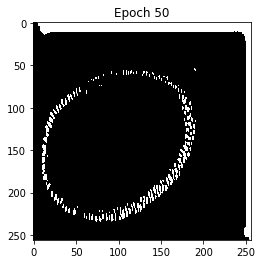

In [9]:
from models import model_extended as md

model = md.create_model(h, w, c)
# print(model.summary())
predictions = md.prediction_history(model, X1_test, X2_test, X3_test, y_test, "unet_extended")  #  1D, 2D, light, resized, rgb, extended
train_generator, test_generator = md.create_generator(X1_train, X1_test, X2_train, X2_test, X3_train, X3_test, y_train, y_test, BATCH_SIZE=BATCH_SIZE, seed=SEED)

model.fit_generator(generator = train_generator,
                    steps_per_epoch = NB_IMAGES_TRAIN//BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=test_generator,
                    validation_steps = NB_IMAGES_TEST//BATCH_SIZE,
                    callbacks = [predictions]
                    )

model.save("models/model_extended.h5")
model.save_weights('models/model_extended_weights.h5')

Let's visualise for few test images the result. The first line is the image, the seond one is the predicted mask and the 3rd one is the given mask

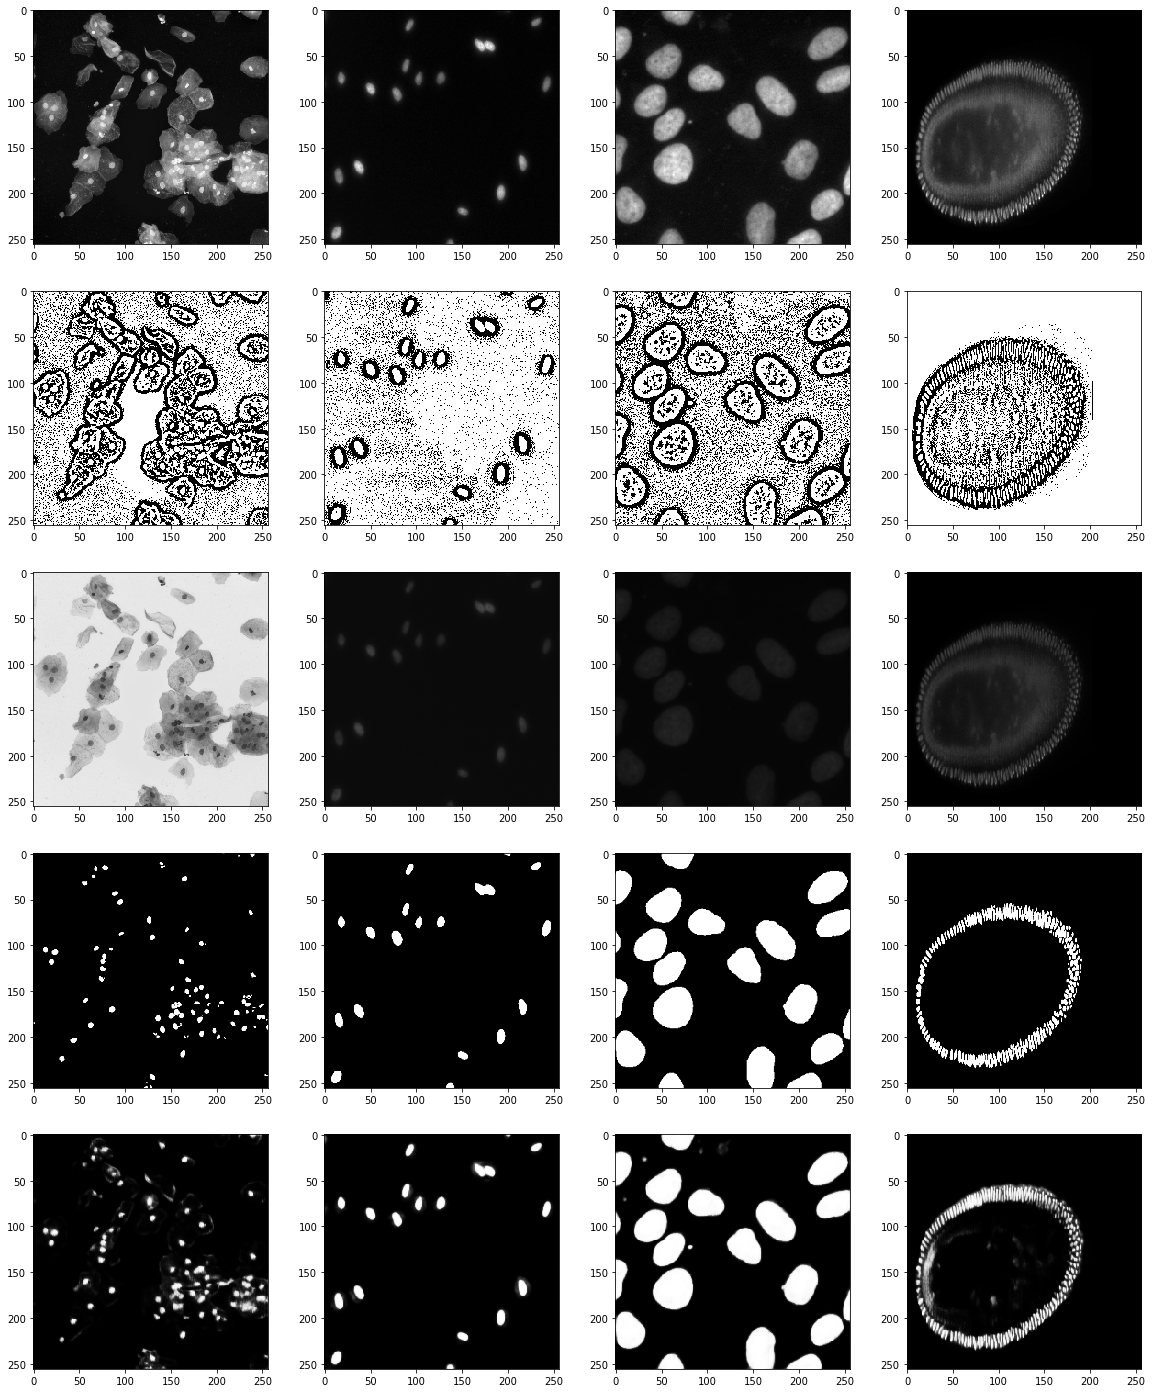

In [29]:
image_list= [8, 11, 12, 24]
f, axarr = plt.subplots(5, len(image_list), figsize=(20,25))
for idx, img_id in enumerate(image_list):
    X1 = X1_test[img_id].astype(np.float64)
    X2 = X2_test[img_id].astype(np.float64)
    X3 = X3_test[img_id].astype(np.float64)
    
    X1 /= 255.
    X2 /= 255.
    X3 /= 255.
    
    X1 = np.expand_dims(X1, 0)
    X2 = np.expand_dims(X2, 0)
    X3 = np.expand_dims(X3, 0)
    
    axarr[0, idx].imshow(X1[0, :, :, 0], cmap='gray')
    axarr[1, idx].imshow(X2[0, :, :, 0], cmap='gray')
    axarr[2, idx].imshow(X3[0])
    axarr[3, idx].imshow(y_test[img_id, :, :, 0], cmap='gray')
    y_pred = model.predict([X1, X2, X3])
    axarr[4, idx].imshow(y_pred[0, :, : , 0], cmap='gray')
plt.savefig("img/prediction_test_extended.png")
plt.show()

the 3 first lines are the inputs. The fouth one is the real mask and the last one is the predicted mask. We can definitely see a huge improvement.

# Evaluation 

At the end of the training, we save the model. We can now evaluation the IoU on test set images. As our output is a sigmoid, we can also adjust our threashold for black/white pixel to improve IoU.

In [5]:
model = load_model("models/model_extended.h5")

In [11]:
final_score = []
threshold = [0.05 * i for i in range(10, 20)]
for t in threshold:
    score = []
    for idx in range(NB_IMAGES_TEST):
        X1 = X1_test[idx].astype(np.float64)
        X2 = X2_test[idx].astype(np.float64)
        X3 = X3_test[idx].astype(np.float64)

        X1 /= 255.
        X2 /= 255.
        X3 /= 255.

        X1 = np.expand_dims(X1, 0)
        X2 = np.expand_dims(X2, 0)
        X3 = np.expand_dims(X3, 0)
        
        y_pred = model.predict([X1, X2, X3])
        
        mask = y_test[idx, :, : , 0]
        pred = y_pred[0, :, :, 0]
        
        dims = dim_test[idx].tolist()
        W, H = dims

        pred = cv2.resize(pred, (H, W))
        mask = cv2.resize(mask, (H, W))
        
#         f, axarr = plt.subplots(1, 2)
#         axarr[0].imshow(pred, cmap='gray')
#         axarr[1].imshow(mask, cmap='gray')
#         plt.show()

        IOU = compute_IoU(pred, mask, trigger=0.5)  # if predicition of a specific pixel is above trigger, it is white
        if IOU >= t:
            score.append(1)
        else:
            score.append(0)
    final_score.append(sum(score)/len(score))
    print("Score (with threshold = {:.2f}) = {:.3f}".format(t, sum(score)/len(score)))
print("Final score = {:.3f}".format(sum(final_score)/len(final_score)))

Score (with threshold = 0.50) = 0.985
Score (with threshold = 0.55) = 0.970
Score (with threshold = 0.60) = 0.940
Score (with threshold = 0.65) = 0.925
Score (with threshold = 0.70) = 0.910
Score (with threshold = 0.75) = 0.836
Score (with threshold = 0.80) = 0.642
Score (with threshold = 0.85) = 0.418
Score (with threshold = 0.90) = 0.239
Score (with threshold = 0.95) = 0.060
Final score = 0.693


We can slightly fine tune the trigger now before to use it for post-processing. for this we will calculate the fianl score for multiple threshold.

In [12]:
result_trigger = []
for trigger in [0.05 * i for i in range(5, 15)]:
    print(trigger)
    final_score = []
    threshold = [0.05 * i for i in range(10, 20)]
    for t in threshold:
        score = []
        for idx in range(NB_IMAGES_TEST):
            X1 = X1_test[idx].astype(np.float64)
            X2 = X2_test[idx].astype(np.float64)
            X3 = X3_test[idx].astype(np.float64)

            X1 /= 255.
            X2 /= 255.
            X3 /= 255.

            X1 = np.expand_dims(X1, 0)
            X2 = np.expand_dims(X2, 0)
            X3 = np.expand_dims(X3, 0)

            y_pred = model.predict([X1, X2, X3])

            mask = y_test[idx, :, : , 0]
            pred = y_pred[0, :, :, 0]

            dims = dim_test[idx].tolist()
            W, H = dims

            pred = cv2.resize(pred, (H, W))
            mask = cv2.resize(mask, (H, W))

    #         f, axarr = plt.subplots(1, 2)
    #         axarr[0].imshow(pred, cmap='gray')
    #         axarr[1].imshow(mask, cmap='gray')
    #         plt.show()

            IOU = compute_IoU(pred, mask, trigger=trigger)  # if predicition of a specific pixel is above trigger, it is white
            if IOU >= t:
                score.append(1)
            else:
                score.append(0)
        final_score.append(sum(score)/len(score))
#         print("Score (with threshold = {:.2f}) = {:.3f}".format(t, sum(score)/len(score)))
    print("Final score = {:.3f}".format(sum(final_score)/len(final_score)))
    result_trigger.append(sum(final_score)/len(final_score))

0.25
Final score = 0.718
0.30000000000000004
Final score = 0.724
0.35000000000000003
Final score = 0.719
0.4
Final score = 0.715
0.45
Final score = 0.715
0.5
Final score = 0.693
0.55
Final score = 0.672
0.6000000000000001
Final score = 0.648
0.65
Final score = 0.627
0.7000000000000001
Final score = 0.597


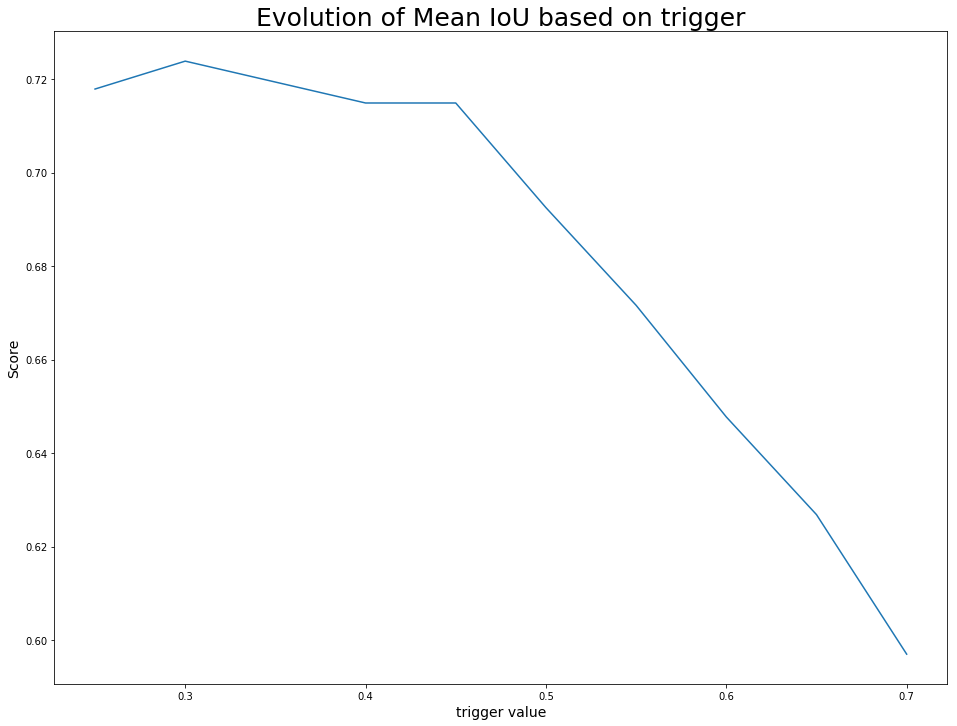

In [13]:
plt.figure(figsize=(16,12))
plt.plot([0.05 * i for i in range(5, 15)], result_trigger)
plt.title("Evolution of Mean IoU based on trigger", fontsize=25)
plt.xlabel("trigger value", fontsize=14)
plt.ylabel("Score", fontsize=14)
plt.savefig("img/Mean_IoU_fct_trigger.png")
plt.show()

A score of 0.45 is a good threshold. We should not use 0.3 which is the best because we need a threshold as big as possible. Because it is applied on the result of the sigmoid of the model. If we use a too low threshold, we will keep noise and increase the union. Let's now visualize the final result :

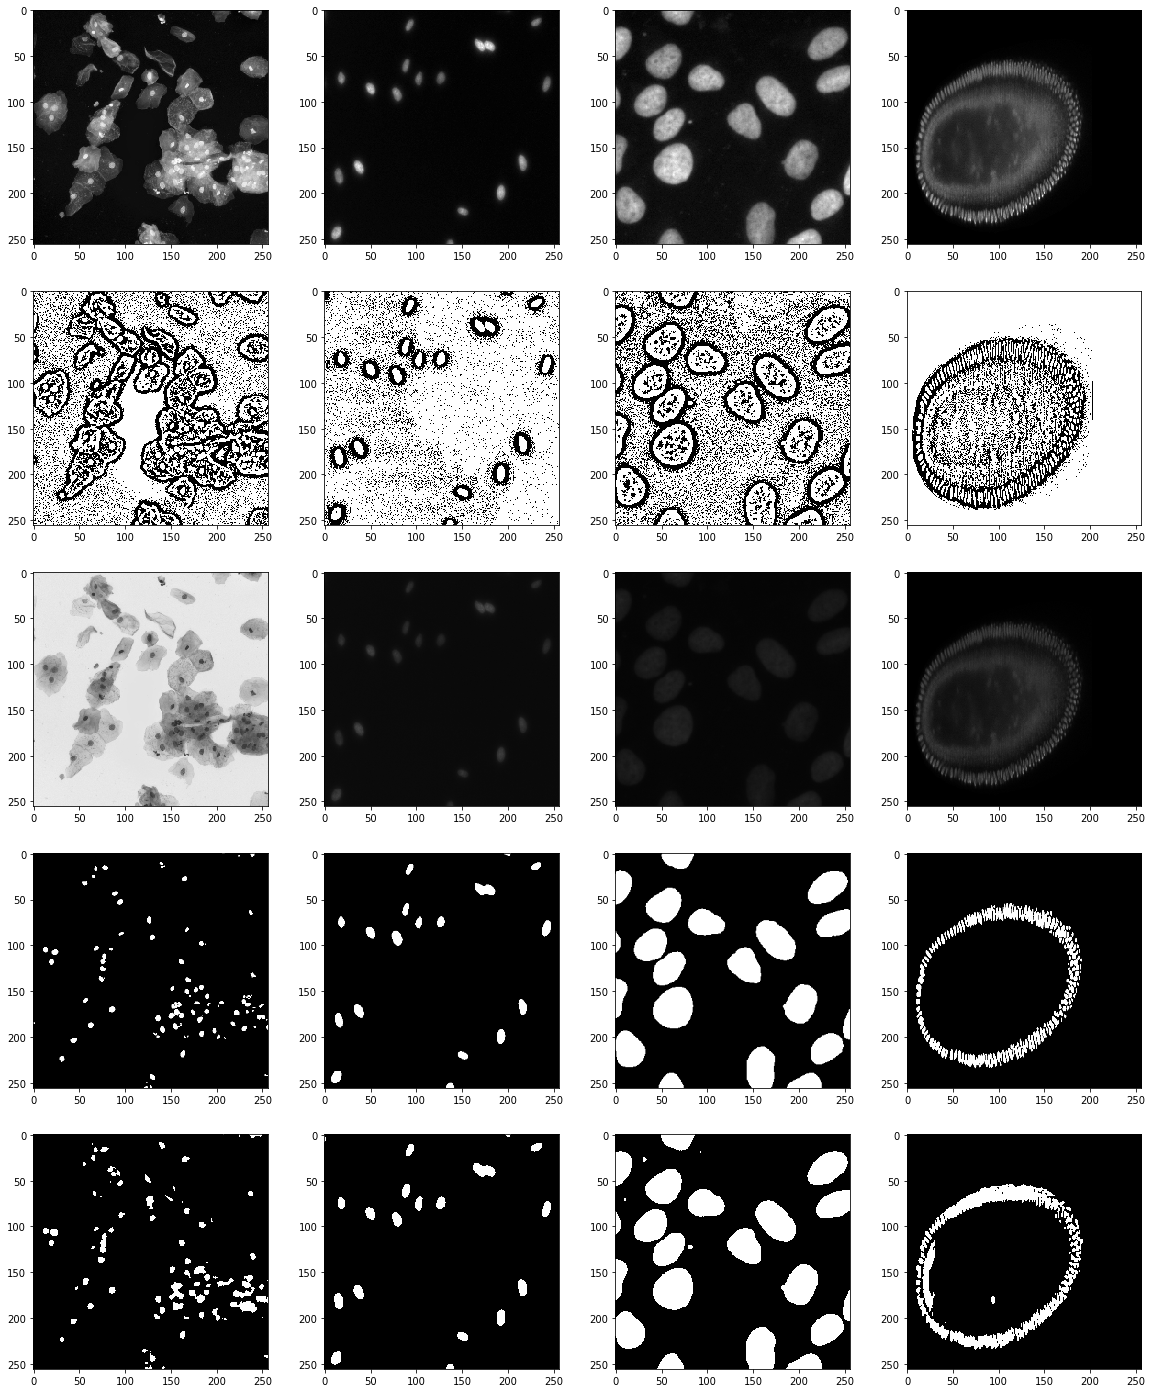

In [58]:
image_list= [8, 11, 12, 24]
f, axarr = plt.subplots(5, len(image_list), figsize=(20,25))
for idx, img_id in enumerate(image_list):
    X1 = X1_test[img_id].astype(np.float64)
    X2 = X2_test[img_id].astype(np.float64)
    X3 = X3_test[img_id].astype(np.float64)
    
    X1 /= 255.
    X2 /= 255.
    X3 /= 255.
    
    X1 = np.expand_dims(X1, 0)
    X2 = np.expand_dims(X2, 0)
    X3 = np.expand_dims(X3, 0)
    
    axarr[0, idx].imshow(X1[0, :, :, 0], cmap='gray')
    axarr[1, idx].imshow(X2[0, :, :, 0], cmap='gray')
    axarr[2, idx].imshow(X3[0])
    axarr[3, idx].imshow(y_test[img_id, :, :, 0], cmap='gray')
    y_pred = model.predict([X1, X2, X3])
    axarr[4, idx].imshow(y_pred[0, :, : , 0]>0.45, cmap='gray')
# plt.savefig("img/prediction_test_extended.png")
plt.show()

Compare to few points before, we can see that we clearly have less noise. We will use this model/trigger in the post processing done uneder another notebook